# Quadrat Based Statistical Method for Planar Point Patterns

**Authors: Serge Rey <sjsrey@gmail.com>, Wei Kang <wkang12@asu.edu> and Hu Shao <Hu.Shao@asu.edu>**

## Introduction

In this notebook, we are going to introduce how to apply quadrat statistics to a point pattern to infer whether it comes from a CSR process.

1. In [Quadrat Statistic](#Quadrat-Statistic) we introduce the concept of quadrat based method.
2. We illustrate how to use the module **quadrat_statistics.py** through an example dataset **juvenile** in [Juvenile Example](#Juvenile-Example)

##  Quadrat Statistic

In the previous notebooks, we introduce the concept of Complete Spaitial Randomness (CSR) process which serves as the benchmark process. Utilizing CSR properties, we can discriminate those that are not from a CSR process. Quadrat statistic is one such method. Since a CSR process has two major characteristics:
1. Uniform: each location has equal probability of getting a point (where an event happens).
2. Independent: location of event points are independent.

We can imagine that for any point pattern, if the underlying process is a CSR process, the expected point counts inside any cell of area $|A|$ should be $\lambda |A|$ ($\lambda$ is the intensity which is uniform across the study area for a CSR). Thus, if we impose a $m \times k$ tessellation over the study area (window), we can easily calculate the expected number of points inside each cell under the null of CSR. By comparing the observed point counts against the expected counts and calculate a $\chi^2$ test statistic, we can decide whether to reject the null based on the position of the $\chi^2$ test statistic in the sampling distribution. 

$$\chi^2 = \sum^m_{i=1} \sum^k_{j=1} \frac{[x_{i,j}-E(x_{i,j})]^2}{\lambda |A_{i,j}|}$$

There are two ways to construct the sampling distribution and acquire a p-value:
1. Analytical sampling distribution: a $\chi^2$ distribution of $m \times k -1$ degree of freedom. We can refer to the $\chi^2$ distribution table to acquire the p-value. If it is smaller than $0.05$, we will reject the null at the $95%$ confidence level.
2. Empirical sampling distribution: a distribution constructed from a large number of $\chi^2$ test statistics for  simulations under the null of CSR. If the $\chi^2$ test statistic for the observed point pattern is among the largest $5%$ test statistics, we would say that it is very unlikely that it is the outcome of a CSR process at the $95%$ confidence level. Then, the null is rejected. A pseudo p-value can be calculated based on which we can use the same rule as p-value to make the decision:
$$p(\chi^2) = \frac{1+\sum^{nsim}_{i=1}\phi_i}{nsim+1}$$
where 
$$ 
\phi_i =
 \begin{cases}
    1       & \quad \text{if } \psi_i^2 \geq \chi^2 \\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

$nsim$ is the number of simulations, $\psi_i^2$ is the $\chi^2$ test statistic calculated for each simulated point pattern, $\chi^2$ is the $\chi^2$ test statistic calculated for the observed point pattern, $\phi_i$ is an indicator variable.

We are going to introduce how to use the **quadrat_statistics.py** module to perform quadrat based method using either of the above two approaches to constructing the sampling distribution and acquire a p-value.


## Juvenile Example

In [1]:
import pysal as ps
import numpy as np
from pointpattern import PointPattern
from process import PoissonPointProcess as csr
from window import as_window
%matplotlib inline
import matplotlib.pyplot as plt

Import the quadrat_statistics module to conduct quadrat-based method. 

Among the three major classes in the module, **RectangleM, HexagonM, QStatistic**, the first two are aimed at imposing a tessellation (rectangle or hexagon shape) over the minimum bounding rectangle of the point pattern and calculate the number of points falling in each cell; **QStatistic** is the main class with which we can calculate a p-value, as well as a pseudo p-value to help us make the decision of rejecting the null or not.

In [2]:
import quadrat_statistics as qs

In [3]:
dir(qs)

['HexagonM',
 'QStatistic',
 'RectangleM',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'csr',
 'math',
 'np',
 'plt',
 'scipy']

Open the point shapefile "juvenile.shp".

In [4]:
juv = ps.open(ps.examples.get_path("juvenile.shp"))

In [5]:
len(juv) # 168 point events in total

168

In [6]:
juv_points = np.array([event for event in juv]) # get x,y coordinates for all the points
juv_points

array([[ 94.,  93.],
       [ 80.,  95.],
       [ 79.,  90.],
       [ 78.,  92.],
       [ 76.,  92.],
       [ 66.,  93.],
       [ 64.,  90.],
       [ 27.,  70.],
       [ 58.,  88.],
       [ 57.,  92.],
       [ 53.,  92.],
       [ 50.,  90.],
       [ 49.,  90.],
       [ 32.,  90.],
       [ 31.,  87.],
       [ 22.,  87.],
       [ 21.,  87.],
       [ 21.,  86.],
       [ 22.,  81.],
       [ 23.,  83.],
       [ 27.,  85.],
       [ 27.,  84.],
       [ 27.,  83.],
       [ 27.,  82.],
       [ 30.,  84.],
       [ 31.,  84.],
       [ 31.,  84.],
       [ 32.,  83.],
       [ 33.,  81.],
       [ 32.,  79.],
       [ 32.,  76.],
       [ 33.,  77.],
       [ 34.,  86.],
       [ 34.,  84.],
       [ 38.,  82.],
       [ 39.,  81.],
       [ 40.,  80.],
       [ 41.,  83.],
       [ 43.,  75.],
       [ 44.,  81.],
       [ 46.,  81.],
       [ 47.,  82.],
       [ 47.,  81.],
       [ 48.,  80.],
       [ 48.,  81.],
       [ 50.,  85.],
       [ 51.,  84.],
       [ 52.,

Construct a point pattern from numpy array **juv_points**.

In [7]:
pp_juv = PointPattern(juv_points)
pp_juv

In [8]:
pp_juv.summary()

Point Pattern
168 points
Bounding rectangle [(2.0,6.0), (94.0,95.0)]
Area of window: 8188.0
Intensity estimate for window: 0.0205178309722
    x   y
0  94  93
1  80  95
2  79  90
3  78  92
4  76  92


/Users/serge/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


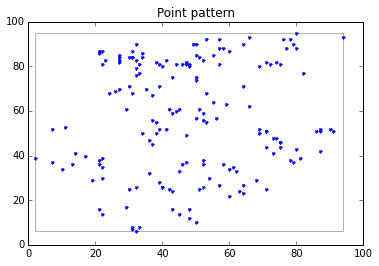

In [9]:
pp_juv.plot(window= True, title= "Point pattern")

### Rectangle quadrats & analytical sampling distribution

We can impose rectangle tessellation over mbb of the point pattern by specifying **shape** as "rectangle". We can also specify the number of rectangles in each row and column. For the current analysis, we use the $3 \times 3$ rectangle grids.

In [10]:
q_r = qs.QStatistic(pp_juv,shape= "rectangle",nx = 3, ny = 3)

Use the plot method to plot the quadrats as well as the number of points falling in each quadrat.

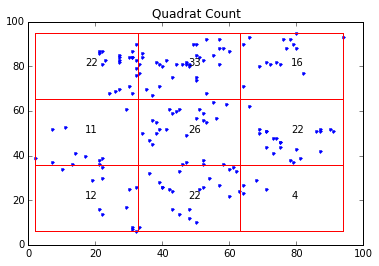

In [11]:
q_r.plot()

In [12]:
q_r.chi2

33.107142857142854

In [13]:
q_r.chi2_pvalue

0.00011781957090319228

Since the p-value based on the analytical $\chi^2$ distribution is 0.0001, much smaller than 0.05. We might determine that the underlying process is not CSR. We can also turn to empirical sampling distribution to ascertain our decision.

### Rectangle quadrats & empirical sampling distribution

To construct a empirical sampling distribution, we need to simulate CSR within the window of the observed point pattern a lot of times. Here, we generate 999 point patterns under the null of CSR.

In [14]:
csr_process = csr(pp_juv.window, pp_juv.n, 999, asPP=True)

We specify parameter **realizations** as the point process instance which contains 999 CSR realizations.

In [15]:
q_r_e = qs.QStatistic(pp_juv,shape= "rectangle",nx = 3, ny = 3, realizations = csr_process)

In [16]:
q_r_e.chi2_r_pvalue

0.001

The pseudo p-value is 0.002, which is smaller than 0.05. Thus, we reject the null at the $95%$ confidence level.

### Hexagon quadrats & analytical sampling distribution

We can also impose hexagon tessellation over mbb of the point pattern by specifying **shape** as "hexagon". We can also specify the length of the hexagon edge. For the current analysis, we specify it as 15.

In [17]:
q_h = qs.QStatistic(pp_juv,shape= "hexagon",lh = 15)

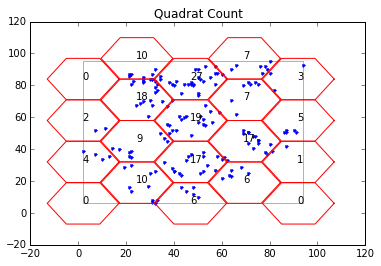

In [18]:
q_h.plot()

In [19]:
q_h.chi2

129.38095238095238

In [20]:
q_h.chi2_pvalue

3.818545786188396e-18

Similar to the inference of rectangle tessellation, since the analytical p-value is much smaller than 0.05, we reject the null of CSR. The point pattern is not random.

### Hexagon quadrats & empirical sampling distribution

In [21]:
q_h_e = qs.QStatistic(pp_juv,shape= "hexagon",lh = 15, realizations = csr_process)

In [22]:
q_h_e.chi2_r_pvalue

0.001

Because 0.001 is smaller than 0.05, we reject the null.